After implementing the same flocking model in two dimensions (2D) and three dimensions (3D) and ran parameter sweeps over:

* Noise (randomness in heading updates),

* Interaction radius (who counts as a neighbor),

* Alignment strength (how strongly an agent matches neighbors).

The goal of this notebook is to produce one clean comparison graph that highlights how motion differs between 2D and 3D at the level of a single agent via studying the difference in diffusivity between dimensions.

Diffusion is defined as the change of a specific bird's position relative position to the flocks center of mass. In simple terms, diffusion is how much a specific moves within the flock while still following the flocks collective motion. 

We quantify diffusion by looking at the average mean squared displacement (MSD) of a single bird over time.

1. Compute flock's center of mass $R_{CM}(t)$ - averaging the positions of all $N$ agents at each time $t$ to get the flock's overall position

2. Compute relative motion to center of mass - subtract each agents position witht the center of mass position $\Rightarrow$ $r_{i}(t) = R_{i}(t) - R_{CM}(t)$

3. Compute MSD to see how much an agent wandered within the flock - for a chosen time lag $\tau$ we take the difference between agent $i$ intial position and the position after time lag $\tau$ to see how far the agent has moved within the flock $\Rightarrow$ $r_{i}(t_{0} + \tau) - r_{i}(t_{0})$

4. We then square the MSD to get the magnitude of the movement and opposite directions do not cancel each other. $\Rightarrow$ $\left\| r_{i}(t_{0} + \tau) - r_{i}(t_{0}) \right\|^{2}$

5. We then average this squared displacement over all starting times $t_{0}$ so we use the whole time series and over all agents 
$i$ so we capture typical behaviour rather than one noisy path.

In [3]:
import os, sys
sys.path.append(os.path.abspath(".."))

os.makedirs(os.path.abspath("../figures"), exist_ok=True)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from src.flocking_sim import run_simulation as run_simulation_2d
from src.flocking_sim_3d import run_simulation as run_simulation_3d
from src.metrics import nearest_neighbor_distance, largest_cluster_fraction


# Default 2d and 3d Flocking Model Settings
N=200
steps=400
box_size=1.0
align=1.0
cohesion=0.5              
noise=0.05
R=0.15
speed=0.03
repulsion_radius=0.05
repulsion_strength=1.0
dt=0.1
seed=None
save_every=1


In [9]:
pos_2d = run_simulation_2d(
    N=N,
    steps=steps,
    box_size=box_size,
    align=align,          
    noise=noise,
    R=R,
    speed=speed,
    dt=dt,
    seed=seed,
    save_every=save_every,
)

pos_3d = run_simulation_3d(
    N=N,
    steps=steps,
    box_size=box_size,
    align=align,
    cohesion=cohesion,               
    noise=noise,
    R=R,
    speed=speed,
    repulsion_radius=repulsion_radius,
    repulsion_strength=repulsion_strength,
    dt=dt,
    seed=seed,
    save_every=save_every,
)



In [16]:

def center_of_mass_positions(positions: np.ndarray) -> np.ndarray:
    """
    positions: array of shape (T, N, d)
    returns: R_cm(t) of shape (T, d)
    """
    return positions.mean(axis=1)

def positions_in_com_frame(positions: np.ndarray) -> np.ndarray:
    """
    Convert positions relative to center of mass r_i(t) = R_i(t) - R_cm(t).

    positions: (T, N, d)
    returns:   (T, N, d)
    """
    R_cm = center_of_mass_positions(positions)      
    return positions - R_cm[:, None, :]       

def unwrap_positions_pbc(positions: np.ndarray, box_size: float) -> np.ndarray:
    """
    Unwrap positions for periodic boundary conditions so trajectories are continuous.

    positions: (T, N, d) positions in [0, box_size)
    box_size:  float, size of periodic box
    returns:   (T, N, d) unwrapped positions
    """
    if box_size is None:
        return positions.copy()

    pos = positions.copy()

    # step displacements (T-1, N, d)
    steps = np.diff(pos, axis=0)

    # bring each step into [-box/2, box/2]
    steps -= box_size * np.round(steps / box_size)

    # reconstruct unwrapped positions
    pos_unwrapped = np.empty_like(pos)
    pos_unwrapped[0] = pos[0]
    pos_unwrapped[1:] = pos_unwrapped[0] + np.cumsum(steps, axis=0)
    return pos_unwrapped

def msd_com_frame(
    positions: np.ndarray,
    dt: float = 1.0,
    save_every: int = 1,
    box_size: float | None = None,
    max_lag: int | None = None,
    average_over_agents: bool = True,
    agent_idx: int = 0,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute mean-squared displacement (MSD) in the center-of-mass frame, following the paper's idea:
      r_i(t) = R_i(t) - R_CM(t)
      MSD(tau) = average_{t0, i} ||r_i(t0+tau) - r_i(t0)||^2

    positions: (T, N, d)
    dt: simulation timestep
    save_every: how often you saved (1 if you saved every step)
    box_size: periodic box size (None if not periodic)
    max_lag: maximum lag in SAVED steps (None -> T-1)
    average_over_agents: True -> average over all agents i (paper-style)
                         False -> compute MSD for one agent only (agent_idx)
    agent_idx: which agent to use if average_over_agents=False

    returns:
      t_lag: (L,) lag times in the same time units as dt
      msd:   (L,) MSD values
    """

    T, N, d = positions.shape

    # 1) unwrap in lab frame if periodic
    pos_u = unwrap_positions_pbc(positions, box_size) if box_size is not None else positions

    # 2) convert to COM frame
    pos_com = positions_in_com_frame(pos_u)  # (T, N, d)


    # 3) choose max lag
    if max_lag is None:
        max_lag = T - 1
    max_lag = int(max_lag)
    if max_lag < 1 or max_lag > T - 1:
        raise ValueError(f"max_lag must be in [1, {T-1}]")

    taus = np.arange(1, max_lag + 1)  # lag in saved steps
    msd = np.empty_like(taus, dtype=float)

    if average_over_agents:
        # paper-style: average over i and t0
        for k, tau in enumerate(taus):
            disp = pos_com[tau:] - pos_com[:-tau]         
            msd[k] = np.mean(np.sum(disp**2, axis=-1)) 
    else:
        # single-agent MSD (still averaged over t0)
        i = int(agent_idx)
        if i < 0 or i >= N:
            raise ValueError(f"agent_idx must be in [0, {N-1}]")
        traj = pos_com[:, i, :]                       
        for k, tau in enumerate(taus):
            disp = traj[tau:] - traj[:-tau]            
            msd[k] = np.mean(np.sum(disp**2, axis=-1))     

    # convert lag steps -> physical time
    t_lag = taus * dt * save_every
    
    return t_lag, msd



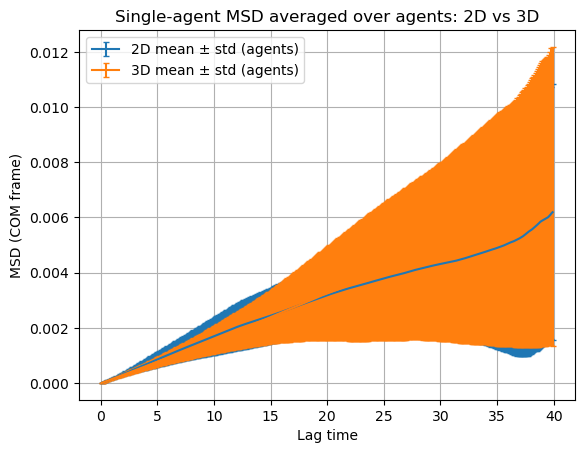

In [22]:
import random

runs = 50

msd2_list = []
msd3_list = []

for _ in range(runs):
    i = random.randint(0, N-1)
    t2, msd2 = msd_com_frame(
        pos_2d,
        dt=dt,
        save_every=1,              # set to your save_every if not 1
        box_size=box_size,         # set to None if no periodic boundaries
        max_lag=None,              # or set e.g. 200
        average_over_agents=False, # single agent
        agent_idx=i
    )

    t3, msd3 = msd_com_frame(
        pos_3d,
        dt=dt,
        save_every=1,
        box_size=box_size,
        max_lag=None,
        average_over_agents=False,
        agent_idx=i
    )

    msd2_list.append(msd2)
    msd3_list.append(msd3)

# --- convert to arrays: (num_agents, num_lags) ---
msd2_arr = np.vstack(msd2_list)
msd3_arr = np.vstack(msd3_list)

# --- average + error bars across agents ---
msd2_mean = msd2_arr.mean(axis=0)
msd3_mean = msd3_arr.mean(axis=0)

msd2_std  = msd2_arr.std(axis=0, ddof=1)   # spread across agents
msd3_std  = msd3_arr.std(axis=0, ddof=1)

# --- 2) Plot overlay (raw MSD) ---
plt.figure()
plt.errorbar(t2, msd2_mean, yerr=msd2_std, fmt='-', capsize=2, label="2D mean ± std (agents)")
plt.errorbar(t3, msd3_mean, yerr=msd3_std, fmt='-', capsize=2, label="3D mean ± std (agents)")
plt.xlabel("Lag time")
plt.ylabel("MSD (COM frame)")
plt.title("Single-agent MSD averaged over agents: 2D vs 3D")
plt.legend()
plt.grid(True)
plt.show()

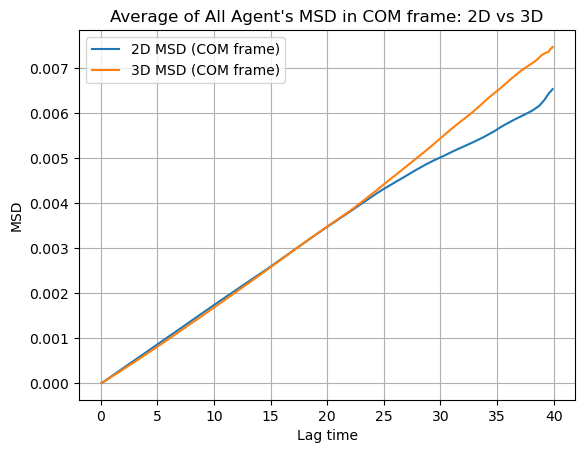

In [18]:
t2, msd2 = msd_com_frame(
    pos_2d,
    dt=dt,
    save_every=1,              # set to your save_every if not 1
    box_size=box_size,         # set to None if no periodic boundaries
    max_lag=None,              # or set e.g. 200
    average_over_agents=True, # single agent
    agent_idx=0
)

t3, msd3 = msd_com_frame(
    pos_3d,
    dt=dt,
    save_every=1,
    box_size=box_size,
    max_lag=None,
    average_over_agents=True,
    agent_idx=0
)

# --- 2) Plot overlay (raw MSD) ---
plt.figure()
plt.plot(t2, msd2, label="2D MSD (COM frame)")
plt.plot(t3, msd3, label="3D MSD (COM frame)")
plt.xlabel("Lag time")
plt.ylabel("MSD")
plt.title("Average of All Agent's MSD in COM frame: 2D vs 3D")
plt.legend()
plt.grid(True)
plt.show()